In [2]:
# Install necessary libraries
!pip install nba_api

from nba_api.stats.endpoints import leaguegamefinder, teamgamelog, playergamelog
from nba_api.stats.static import teams, players
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

#Fetch NBA Stats from NBA official site using NBA-API
def fetch_all_game_data():
    """
    Fetches the most recent 100 NBA game data from the API for all teams.
    Returns a DataFrame with historical game data.
    """
    nba_teams = teams.get_teams()
    all_games = []
    for team in nba_teams:
        team_id = team['id']
        gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
        team_games = gamefinder.get_data_frames()[0]
        team_games['TEAM_ID'] = team_id
        all_games.append(team_games)
        time.sleep(1)  # Prevent rate limiting
    return pd.concat(all_games, ignore_index=True)

def fetch_team_stats():
    """
    Fetches team stats for all teams.
    Returns a DataFrame with team stats.
    """
    nba_teams = teams.get_teams()
    all_team_stats = []
    for team in nba_teams:
        team_id = team['id']
        stats = teamgamelog.TeamGameLog(team_id=team_id).get_data_frames()[0]
        stats['TEAM_ID'] = team_id
        all_team_stats.append(stats)
        time.sleep(1)
    return pd.concat(all_team_stats, ignore_index=True)

In [3]:

def contains_alpha(col):
    if col.dtype == 'object':
        return col.str.contains(r'[a-zA-Z]', na=False).any()

    return False


# Add opponent team ID to each line of data df according to abbreviations
def add_opponent_team_id(data):
    nba_teams = teams.get_teams()
    team_abbr_to_id = {team['abbreviation']: int(team['id']) for team in nba_teams}
    data['OPPONENT_ABBR'] = data['MATCHUP'].apply(lambda x: x.split(' ')[-1])
    data['OPPONENT_ABBR'] = data['OPPONENT_ABBR'].str.strip().str.upper()
    data['OPPONENT_TEAM_ID'] = data['OPPONENT_ABBR'].map(team_abbr_to_id).astype('Int64')
    data.drop(columns=['OPPONENT_ABBR'], inplace=True)

    return data


# Add relevant opponent stats to each line of data df
def add_opponent_stats(data, team_stats_copy):
    opponent_stats = team_stats_copy.copy()
    opponent_stats = opponent_stats.rename(columns={
        'TEAM_ID': 'OPPONENT_TEAM_ID',
        'W': 'OPPONENT_W',
        'L': 'OPPONENT_L',
        'W_PCT': 'OPPONENT_W_PCT',
        'Home': 'OPPONENT_Home',
        'Win_Pct_Last_10': 'OPPONENT_Win_Pct_Last_10',
        'Win_Streak': 'OPPONENT_Win_Streak',
        'TARGET': 'OPPONENT_TARGET'
    })
    data = data.merge(opponent_stats,
                      left_on=['Game_ID', 'OPPONENT_TEAM_ID'],
                      right_on=['Game_ID', 'OPPONENT_TEAM_ID'],
                      how='left')
    data.fillna(0, inplace=True)

    return data


# Main preprocessing function
def preprocess_data(games_copy, team_stats_copy, player_stats):
    #remove in-game stats, leave all pre-game stats
    to_drop_g_col = ['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                    'TOV', 'PF', 'PLUS_MINUS']
    games_copy.drop(columns=[col for col in to_drop_g_col if col in games_copy.columns], inplace=True)
    to_drop_t_col = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
                    'BLK', 'TOV', 'PF', 'PTS']
    team_stats_copy.drop(columns=[col for col in to_drop_t_col if col in team_stats_copy.columns], inplace=True)

    data = games_copy.merge(team_stats_copy, left_on=['GAME_ID','TEAM_ID'], right_on=['Game_ID', 'Team_ID'], how='left', suffixes=('', '_drop'))
    data = data[[c for c in data.columns if not c.endswith('_drop')]]

    data = add_opponent_team_id(data)
    data = add_opponent_stats(data, team_stats_copy)

    #create new features
    data['TARGET'] = (data['WL_x'] == 'W').astype(int)
    data['Home'] = data['MATCHUP_x'].apply(lambda x: 1 if '@' in x else 0)
    data['Win_Pct_Last_10'] = data.groupby('TEAM_ID')['W'].rolling(window=10).mean().reset_index(drop=True)
    data['Win_Streak'] = data.groupby('TEAM_ID')['W'].rolling(window=5).sum().reset_index(drop=True)

    #drop unnecessary columns
    columns_to_drop = ['GAME_DATE', 'GAME_DATE_x', 'MATCHUP', 'GAME_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
                       'TEAM_ID_TEAM', 'Team_ID', 'WL', 'Team_ID_x',  'Team_ID_y']
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

    columns_to_drop2 = [col for col in data.columns if contains_alpha(data[col])]
    if columns_to_drop2:
        data.drop(columns=[col for col in columns_to_drop2 if col in data.columns], inplace=True)

    #remove irrelevant lines with NaN values
    data.fillna(0, inplace=True)
    data = data[data['Game_ID'] != 0]

    return data


#Prepare Data for Tabular Transformer
def prepare_data_for_transformer(data):
    """
    Splits the data into train, validation, and test sets and scales numeric features.
    """
    # Split data into features and target
    X = data
    y = data['TARGET']

    # Split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Define features for Standard and MinMax normalization
    standard_features = ['W', 'L', 'OPPONENT_W', 'OPPONENT_L', 'W_PCT', 'Win_Pct_Last_10', 'Win_Streak']
    minmax_features = ['SEASON_ID', 'TEAM_ID', 'Game_ID', 'OPPONENT_TEAM_ID', 'OPPONENT_W_PCT', 'Home']

    # Standard Scaling
    existing_standard_columns =[col for col in standard_features if col in X_train]
    standard_scaler = StandardScaler()
    X_train[existing_standard_columns] = standard_scaler.fit_transform(X_train[existing_standard_columns])
    X_val[existing_standard_columns] = standard_scaler.transform(X_val[existing_standard_columns])
    X_test[existing_standard_columns] = standard_scaler.transform(X_test[existing_standard_columns])

    # MinMax Scaling
    existing_minmax_columns = [col for col in minmax_features if col in X_train]
    minmax_scaler = MinMaxScaler()
    X_train[existing_minmax_columns] = minmax_scaler.fit_transform(X_train[existing_minmax_columns])
    X_val[existing_minmax_columns] = minmax_scaler.transform(X_val[existing_minmax_columns])
    X_test[existing_minmax_columns] = minmax_scaler.transform(X_test[existing_minmax_columns])

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
#Data fetch
print("Fetching game data...")
games = fetch_all_game_data()

print("Fetching team stats...")
team_stats = fetch_team_stats()

"""
#temporarily removed, TODO: add back to model
print("Fetching player stats...")
player_stats = fetch_player_stats()
"""


Fetching game data...
Fetching team stats...


' \n#temporarily removed, TODO: add back to model\nprint("Fetching player stats...")\nplayer_stats = fetch_player_stats()\n'

In [5]:
#preserve original data, work on copies
games_copy = games.copy()
#games_copy = games_copy.sample(n=100, random_state=42)################## TODO: REMOVE
team_stats_copy = team_stats.copy()
player_stats_copy = 0 #player_stats.copy()

print("Preprocessing data...")
data = preprocess_data(games_copy, team_stats_copy, player_stats_copy)

print("Preparing data for Tabular Transformer...")
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_transformer(data)

print("Data is ready!")
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Preprocessing data...
##############################idan:1
Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL'],
      dtype='object')
Index(['Team_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'W', 'L', 'W_PCT',
       'TEAM_ID'],
      dtype='object')
##############################idan:2
Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'Team_ID', 'Game_ID', 'W', 'L', 'W_PCT'],
      dtype='object')
*********************************shadi-1
       SEASON_ID     TEAM_ID TEAM_ABBREVIATION          TEAM_NAME     GAME_ID  \
0          22024  1610612737               ATL      Atlanta Hawks  0022400686   
1          22024  1610612737               ATL      Atlanta Hawks  0022400675   
2          22024  1610612737               ATL      Atlanta Hawks  0022400532   
3          22024  1610612737               ATL      Atlanta Hawks  0022400656   
4          22024  16106127

[I 2025-02-03 23:26:12,650] A new study created in memory with name: no-name-1cf69d1c-9ef9-462a-9729-d820b07b20c9
<ipython-input-8-dc4fa9dcc6b5>:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-8-dc4fa9dcc6b5>:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: CategoryEmbeddingModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  2.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    362 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 2.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 41.4 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    282 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 41.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 41.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  148 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    442 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 149 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 149 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  3.4 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    484 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 3.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 15.8 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    172 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 16.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  122 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    490 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 123 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 123 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  9.7 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    110 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 9.8 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.8 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  2.6 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    370 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 3.0 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │    448 │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │     66 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 540                                                                                              
Non-trainable params: 0                                                                                            
Total params: 540                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 24.1 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    298 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 24.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 66.8 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    504 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 67.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 67.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 17.3 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    180 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 17.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 17.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 21.6 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    202 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 21.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 21.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 19.2 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    190 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 19.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_tabular.tabular_model:Preparing the Model: CategoryEmbeddingModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 50.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    256 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 50.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 50.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 44.7 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    410 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 45.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  6.9 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    112 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 7.1 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.1 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 30.0 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    334 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 30.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 30.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 43.1 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    236 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 43.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 43.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │ 10.1 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    136 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 10.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Index(['TARGET_0_probability', 'TARGET_1_probability', 'TARGET_prediction'], dtype='object')
Best Parameters: {'learning_rate': 0.0016187188164923786, 'dropout': 0.22442780690812156, 'hidden_layers': 3, 'hidden_dim': 244, 'batch_size': 128}


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  122 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     26 │ train │
│ 2 │ head             │ LinearHead                │    490 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 123 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 123 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Final Test Accuracy: 0.6743119266055045


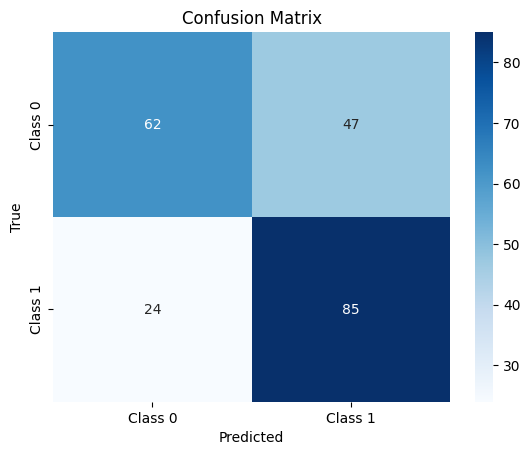

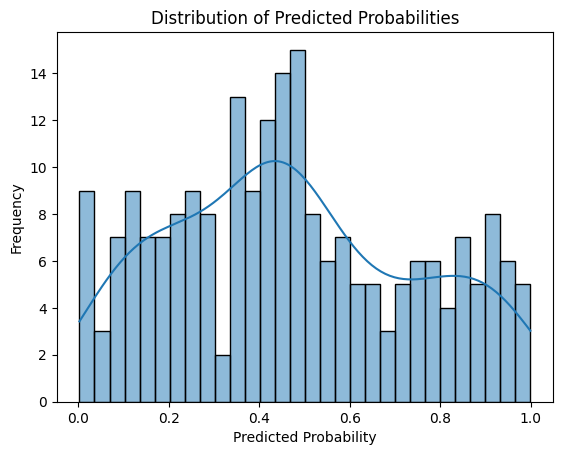

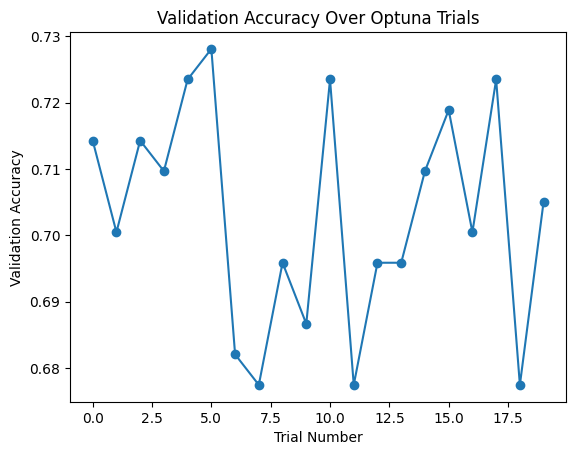

Final Test Accuracy: 0.6743119266055045


In [8]:
# Uncomment to install necessary libraries
!pip install optuna pytorch-tabular

import optuna
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from sklearn.metrics import accuracy_score

import optuna.visualization as vis
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Step 1: Define the Objective Function
def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 4)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Data Configuration
    data_config = DataConfig(
        target=['TARGET'],
        continuous_cols=[col for col in data.columns if col != 'TARGET'],
        categorical_cols=[],
    )

    # Model Configuration
    model_config = CategoryEmbeddingModelConfig(
        task="classification",
        layers="-".join([str(hidden_dim)] * hidden_layers),
        activation="ReLU",
        dropout=dropout,
    )

    # Trainer Configuration
    trainer_config = TrainerConfig(
        auto_lr_find=False,
        batch_size=batch_size,
        max_epochs=40,#originally was 20
    )

    # Optimizer Configuration
    optimizer_config = OptimizerConfig(
        optimizer="Adam",
    )

    # Initialize the Tabular Model
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config
    )

    # Train the model
    tabular_model.fit(train=X_train, validation=X_val)

    # Predict and evaluate
    preds = tabular_model.predict(X_val)
    print(preds.columns)
    accuracy = accuracy_score(y_val, preds['TARGET_prediction'])

    return accuracy

# Step 2: Create Study and Optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)#was 50 originally

# Step 3: Train Final Model with Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

data_config = DataConfig(
        target=['TARGET'],
        continuous_cols=[col for col in data.columns if col != 'TARGET'],
        categorical_cols=[],
    )

final_model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="-".join([str(best_params['hidden_dim'])] * best_params['hidden_layers']),
    activation="ReLU",
    dropout=best_params['dropout'],
)

final_trainer_config = TrainerConfig(
    auto_lr_find=False,
    batch_size=best_params['batch_size'],
    max_epochs=300,
)

final_optimizer_config = OptimizerConfig(
    optimizer="Adam",
    #learning_rate=best_params['learning_rate']
)

final_model = TabularModel(
    data_config=data_config,
    model_config=final_model_config,
    optimizer_config=final_optimizer_config,
    trainer_config=final_trainer_config
)

final_model.fit(train=X_train, validation=X_val)

# Step 4: Evaluate on Test Set
final_preds = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_preds['TARGET_prediction'])
print(f"Final Test Accuracy: {final_accuracy}")


# plot confusion matrix
final_preds = final_model.predict(X_test)
y_pred = final_preds['TARGET_prediction']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# plot predicted probabilities distribution
y_pred_proba = final_model.predict(X_test)['TARGET_0_probability']
plt.figure()
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# Plot validation accuracy over trials
trials = study.trials_dataframe()
plt.figure()
plt.plot(trials['number'], trials['value'], marker='o')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Optuna Trials')
plt.show()

# Plot parameter importance
fig = vis.plot_param_importances(study)
fig.show()

# Plot parallel coordinate plot
fig = vis.plot_parallel_coordinate(study)
fig.show()


print(f"Final Test Accuracy: {final_accuracy}")
